### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_train = pd.read_csv('./NLP3/train.csv')
df_test = pd.read_csv('./NLP3/test.csv')
df_val = df_train.sample(frac = 0.1)

In [3]:
df_train.head()

,index,text,label
0,0,Zimbabwe annual inflation drops to 209 percent...,0
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0
3,3,Security No. 1 for Afghan head President Hamid...,0
4,4,Palestinians say they hope Bush accepts dealin...,0


### Preprocess Text

In [4]:
# Function to clean the text data
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Replace '\\' with a space
    text = re.sub(r'\\', ' ', text)
    # Replace '\\\\' with <space>
    text = text.replace('\\\\', ' ')
    # Encode numbers and dates
    # text = re.sub(r'\b\d+(\.\d+)?\b', '<num>', text)
    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]

    return ' '.join(filtered_text)

In [5]:
# Clean the text for both train and test datasets
df_train['cleaned_text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['cleaned_text'] = df_test['text'].apply(lambda x: clean_text(x))
df_val['cleaned_text'] = df_val['text'].apply(lambda x: clean_text(x))

df_train.head()

,index,text,label,cleaned_text
0,0,Zimbabwe annual inflation drops to 209 percent...,0,zimbabwe annual inflation drops percent report...
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0,dead haiti mass grave haiti holds bodies may m...
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0,seven die japan suicide pact japanese police f...
3,3,Security No. 1 for Afghan head President Hamid...,0,security afghan head president hamid karzai pr...
4,4,Palestinians say they hope Bush accepts dealin...,0,palestinians say hope bush accepts dealing ara...


### Create Vocabulary

In [6]:
# Extract the cleaned sentences from the dataframe
train_texts = df_train['cleaned_text']

# Initialize CountVectorizer with min_df and max_df thresholds
vectorizer = CountVectorizer(min_df=4, max_df=0.95)

# Fit the vectorizer to the texts to create the vocabulary
X = vectorizer.fit_transform(train_texts)

# The vocabulary can be accessed via the get_feature_names_out() method
try:
  vocabulary = vectorizer.get_feature_names()
except AttributeError:
  vocabulary = vectorizer.get_feature_names_out()

# Information about the vocabulary
print(f"Vocabulary Size: {len(vocabulary)}")
print("Sample Words from Vocabulary:", vocabulary[:8])

Vocabulary Size: 2590
Sample Words from Vocabulary: ['aaron' 'abbas' 'abidjan' 'ability' 'able' 'aboard' 'abroad' 'abu']


In [7]:
# Function to remove OOV words from sentences
def remove_oov_words(sentence, vocab):
    tokens = sentence.split()
    final_tokens = [word for word in tokens if word in vocab]
    return ' '.join(final_tokens)

In [8]:
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x: remove_oov_words(x, vocabulary))
df_test['cleaned_text'] = df_test['cleaned_text'].apply(lambda x: remove_oov_words(x, vocabulary))
df_val['cleaned_text'] = df_val['cleaned_text'].apply(lambda x: remove_oov_words(x, vocabulary))

df_train.head()

,index,text,label,cleaned_text
0,0,Zimbabwe annual inflation drops to 209 percent...,0,zimbabwe annual inflation drops percent report...
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0,dead haiti mass haiti holds bodies may many re...
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0,seven die japan suicide pact japanese police f...
3,3,Security No. 1 for Afghan head President Hamid...,0,security afghan head president hamid karzai pr...
4,4,Palestinians say they hope Bush accepts dealin...,0,palestinians say hope bush dealing arafat new ...


### Generate embeddings

In [9]:
# Function to convert sentences to vectors (averaging word vectors)
def sentence_to_vector(sentence, model):
    # tokens = word_tokenize(sentence)
    tokens = sentence.split()
    vector_list = [model.wv[word] for word in tokens if word in model.wv]
    if len(vector_list) == 0:
        return np.zeros(model.vector_size) # Return a zero vector if sentence has no words in vocab
    sentence_vector = np.mean(vector_list, axis=0)
    return sentence_vector

In [10]:
# Prepare data for Word2Vec model (combine all tokenized sentences)
train_sentences = [sentence.split() for sentence in df_train['cleaned_text'].tolist()]

In [11]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=10, epochs=25)

# Apply the function to each sentence
df_train['sentence_vector'] = df_train['cleaned_text'].apply(lambda x: sentence_to_vector(x, word2vec_model))
df_val['sentence_vector'] = df_val['cleaned_text'].apply(lambda x: sentence_to_vector(x, word2vec_model))
df_test['sentence_vector'] = df_test['cleaned_text'].apply(lambda x: sentence_to_vector(x, word2vec_model))

### Train and Evaluate Function

In [12]:
# Function to evaluate validation loss
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, scheduler=True, step_size=100):
    # Initialize the device, loss criterion, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Initialize the learning rate scheduler
    if scheduler:
        sh = StepLR(optimizer, step_size=step_size, gamma=0.1)

    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    best_model_wts = None
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        if epoch % 10 == 0 or epoch == num_epochs-1:
            print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy*100:.2f}%')

        # Check if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict()

        # Step the scheduler
        if scheduler:
            sh.step()

    print(f'\nTraining complete.\nBest Validation Loss : {best_val_loss}, Best Validation Accuracy: {best_val_accuracy*100:.2f}%')
    model.load_state_dict(best_model_wts)
    return model

def print_metrics(model_name, test_loader):
    # Load the best model
    with open(model_name, "rb") as f:
        model = pickle.load(f)

    # Ensure the model is in evaluation mode
    model.eval()

    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate accuracy and macro F1 score
    test_accuracy = accuracy_score(true_labels, predictions)
    macro_f1 = f1_score(true_labels, predictions, average='macro')
    cls_report = classification_report(true_labels, predictions)

    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Macro F1 Score: {macro_f1:.4f}')

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues",
                xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'],
                yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print(cls_report)

    return predictions


### Neural Network

In [13]:
class NewsClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NewsClassifier, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.relu_1 = nn.ReLU()
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.relu_2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, num_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu_1(self.input_layer(x))
        x = self.relu_2(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

In [14]:
X_train = np.array(df_train['sentence_vector'].tolist())
y_train = df_train['label'].tolist()
X_val = np.array(df_val['sentence_vector'].tolist())
y_val = df_val['label'].tolist()
X_test = np.array(df_test['sentence_vector'].tolist())
y_test = df_test['label'].tolist()

batch_size = 64

# Convert the datasets to PyTorch tensors, then wrap them in TensorDatasets
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

# Create DataLoaders for both datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [15]:
# Size of the Word2Vec feature vectors is 100
input_size = 100
hidden_size = 50
num_classes = 4

# Initialize the model
dnn_model = NewsClassifier(input_size, hidden_size, num_classes)

In [16]:
best_dnn_model = train_model(model = dnn_model, train_loader = train_loader, val_loader = val_loader, num_epochs = 100, learning_rate = 1e-3, scheduler=True, step_size=50)

# Save the best DNN model to a pickle file
with open("best_dnn_model.pkl", "wb") as f:
    pickle.dump(best_dnn_model, f)

Epoch 1, Validation Loss: 1.065, Validation Accuracy: 76.50%
Epoch 11, Validation Loss: 0.452, Validation Accuracy: 83.00%
Epoch 21, Validation Loss: 0.418, Validation Accuracy: 82.50%
Epoch 31, Validation Loss: 0.484, Validation Accuracy: 83.50%
Epoch 41, Validation Loss: 0.368, Validation Accuracy: 84.50%
Epoch 51, Validation Loss: 0.315, Validation Accuracy: 86.00%
Epoch 61, Validation Loss: 0.334, Validation Accuracy: 86.00%
Epoch 71, Validation Loss: 0.363, Validation Accuracy: 86.00%
Epoch 81, Validation Loss: 0.388, Validation Accuracy: 86.50%
Epoch 91, Validation Loss: 0.488, Validation Accuracy: 86.00%
Epoch 100, Validation Loss: 0.380, Validation Accuracy: 85.50%

Training complete.
Best Validation Loss : 0.314602255821228, Best Validation Accuracy: 86.00%


Test Accuracy: 0.8080
Macro F1 Score: 0.8077


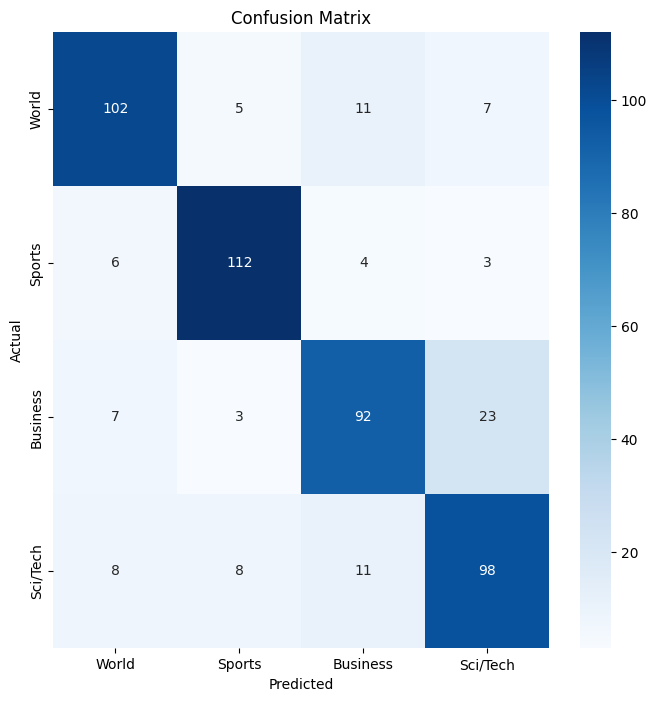

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       125
           1       0.88      0.90      0.89       125
           2       0.78      0.74      0.76       125
           3       0.75      0.78      0.77       125

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



In [17]:
predictions = print_metrics('best_dnn_model.pkl', test_loader)

In [18]:
# Save predictions in CSV
test_data_with_preds = df_test.copy() 
test_data_with_preds = test_data_with_preds.drop(['cleaned_text', 'sentence_vector'], axis=1)
test_data_with_preds['preds'] = predictions  # Add a column for predictions
test_data_with_preds.to_csv('w2v_test.csv', index=False)

### RNN

In [19]:
class NewsDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = torch.tensor(self.sentences[idx])
        label = torch.tensor(self.labels[idx])
        return sentence, label

In [20]:
word2index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key)}
word2index['<PAD>'] = len(word2index)

In [21]:
# Tokenize and encode sentences
def pad_tokenize_encode(sentence, word2index, max_seq_len):
    tokens = word_tokenize(sentence)
    tokens = [word2index[token] for token in tokens if token in list(word2index.keys())]
    if len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]
    elif len(tokens) < max_seq_len:
        padding = [word2index['<PAD>']] * (max_seq_len - len(tokens))
        tokens.extend(padding)

    return tokens

In [22]:
# Hyperparameters
MAX_SEQ_LEN = 100
BATCH_SIZE = 32

df_train['encoded_text'] = df_train['cleaned_text'].apply(lambda x: pad_tokenize_encode(x, word2index, MAX_SEQ_LEN))
df_val['encoded_text'] = df_val['cleaned_text'].apply(lambda x: pad_tokenize_encode(x, word2index, MAX_SEQ_LEN))
df_test['encoded_text'] = df_test['cleaned_text'].apply(lambda x: pad_tokenize_encode(x, word2index, MAX_SEQ_LEN))

# Initialize dataset and dataloader
train_dataset = NewsDataset(df_train['encoded_text'].tolist(), df_train['label'].tolist())
val_dataset = NewsDataset(df_val['encoded_text'].tolist(), df_val['label'].tolist())
test_dataset = NewsDataset(df_test['encoded_text'].tolist(), df_test['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
# Prepare the embedding matrix
word_vectors = word2vec_model.wv
pretrained_embeddings = torch.tensor(word_vectors.vectors)
embedding_dim = word2vec_model.vector_size # 100 as per configuration

PAD_embedding = torch.zeros(1, embedding_dim)
pretrained_embeddings = torch.cat((pretrained_embeddings, PAD_embedding), dim=0)
vocab_size = pretrained_embeddings.shape[0]

In [24]:
class VanillaRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, bidirectional, pretrained_embeddings):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        # self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        embedded = self.embedding(text)
        rnn_output, hidden = self.rnn(embedded)
        avg_output = torch.mean(rnn_output, dim=1)
        avg_output = self.dropout(avg_output)
        logits = self.fc(avg_output)
        return logits

In [25]:
hidden_dim = 100
output_dim = 4
bidirectional = True

rnn_model = VanillaRNN(embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, bidirectional=bidirectional, pretrained_embeddings=pretrained_embeddings)

In [26]:
best_rnn_model = train_model(model = rnn_model, train_loader = train_loader, val_loader = val_loader, num_epochs = 50, learning_rate = 1e-3, scheduler=True, step_size=20)

# Save the best RNN model to a pickle file
with open("best_rnn_model.pkl", "wb") as f:
    pickle.dump(best_rnn_model, f)

Epoch 1, Validation Loss: 1.094, Validation Accuracy: 76.50%
Epoch 11, Validation Loss: 0.519, Validation Accuracy: 80.50%
Epoch 21, Validation Loss: 0.452, Validation Accuracy: 84.50%
Epoch 31, Validation Loss: 0.468, Validation Accuracy: 83.50%
Epoch 41, Validation Loss: 0.475, Validation Accuracy: 84.50%
Epoch 50, Validation Loss: 0.465, Validation Accuracy: 84.50%

Training complete.
Best Validation Loss : 0.42574535948889597, Best Validation Accuracy: 86.00%


Test Accuracy: 0.7980
Macro F1 Score: 0.7977


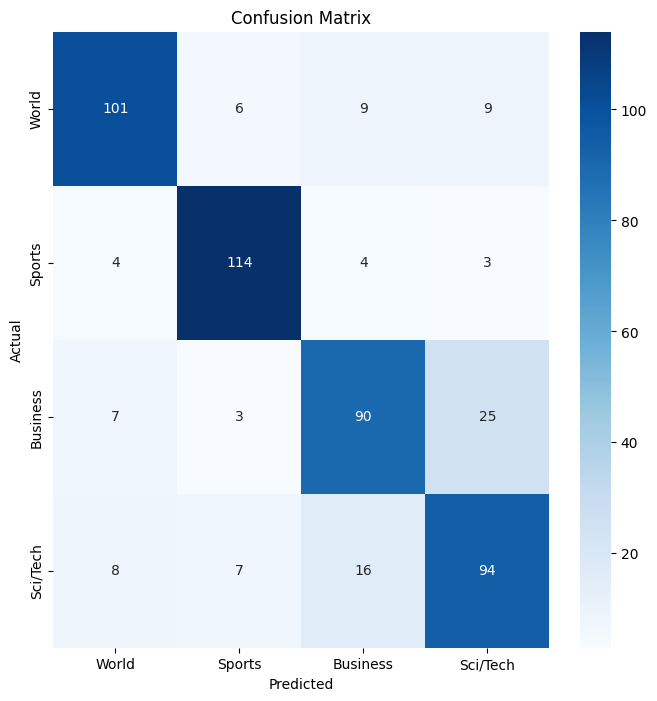

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       125
           1       0.88      0.91      0.89       125
           2       0.76      0.72      0.74       125
           3       0.72      0.75      0.73       125

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



In [27]:
predictions = print_metrics('best_rnn_model.pkl', test_loader)

In [28]:
# Save predictions in CSV
test_data_with_preds = df_test.copy()
test_data_with_preds = test_data_with_preds.drop(['cleaned_text', 'sentence_vector', 'encoded_text'], axis=1)
test_data_with_preds['preds'] = predictions  # Add a column for predictions
test_data_with_preds.to_csv('rnn_test.csv', index=False)

### LSTM

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, pretrained_embeddings):
        super(LSTMModel, self).__init__()
        # Embedding layer with pre-trained embeddings
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        # self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        text = text.long()
        embedded = self.embedding(text)  # embedded shape: [batch_size, max_sentence_length, embedding_dim]
        output, (hidden, cell) = self.lstm(embedded)  # output shape: [batch_size, max_sentence_length, hidden_dim * 2]
        avg_output = torch.mean(output, dim=1)  # avg_output shape: [batch_size, hidden_dim * 2]
        avg_output = self.dropout(avg_output)
        logits = self.fc(avg_output)  # logits shape: [batch_size, output_dim]
        return logits

In [30]:
hidden_dim = 128
output_dim = 4

lstm_model = LSTMModel(embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, pretrained_embeddings=pretrained_embeddings)

In [31]:
best_lstm_model = train_model(model = lstm_model, train_loader = train_loader, val_loader = val_loader, num_epochs = 50, learning_rate = 0.001, scheduler=True, step_size=20)

# Save the best lstm model to a pickle file
with open("best_lstm_model.pkl", "wb") as f:
    pickle.dump(best_lstm_model, f)

Epoch 1, Validation Loss: 1.163, Validation Accuracy: 75.50%
Epoch 11, Validation Loss: 0.523, Validation Accuracy: 81.50%
Epoch 21, Validation Loss: 0.484, Validation Accuracy: 83.00%
Epoch 31, Validation Loss: 0.442, Validation Accuracy: 85.50%
Epoch 41, Validation Loss: 0.455, Validation Accuracy: 85.50%
Epoch 50, Validation Loss: 0.444, Validation Accuracy: 85.00%

Training complete.
Best Validation Loss : 0.4298352875879833, Best Validation Accuracy: 86.50%


Test Accuracy: 0.8000
Macro F1 Score: 0.7995


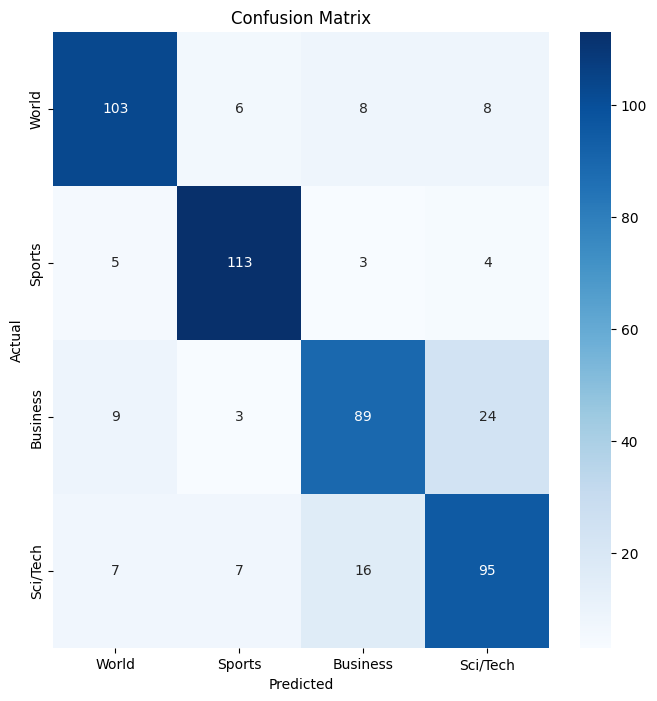

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       125
           1       0.88      0.90      0.89       125
           2       0.77      0.71      0.74       125
           3       0.73      0.76      0.74       125

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



In [32]:
predictions = print_metrics('best_lstm_model.pkl', test_loader)

In [33]:
# Save predictions in CSV
test_data_with_preds = df_test.copy()
test_data_with_preds = test_data_with_preds.drop(['cleaned_text', 'sentence_vector', 'encoded_text'], axis=1)
test_data_with_preds['preds'] = predictions  # Add a column for predictions
test_data_with_preds.to_csv('lstm_test.csv', index=False)